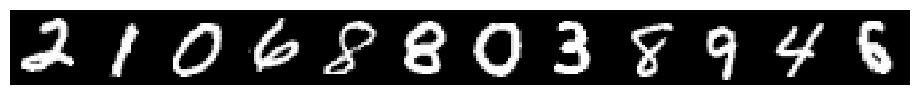

In [3]:
import utils
X,T = utils.loaddata()
%matplotlib inline
utils.digit(X.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)

In [4]:
W,B = utils.loadparams()
L = len(W)

In [5]:
import numpy
A = [X]+[None]*L
for l in range(L):
    A[l+1] = numpy.maximum(0,A[l].dot(W[l])+B[l])

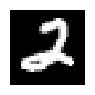

[0] 0.0  [1] 3.6  [2] 49.1  [3] 8.9  [4] 0.0  [5] 0.0  [6] 0.0  [7] 1.4  [8] 1.6  [9] 0.0


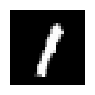

[0] 0.0  [1] 27.0  [2] 0.0  [3] 0.0  [4] 5.3  [5] 0.0  [6] 0.0  [7] 13.0  [8] 8.1  [9] 2.3


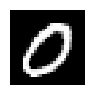

[0] 49.1  [1] 0.0  [2] 10.6  [3] 0.0  [4] 0.0  [5] 0.2  [6] 0.0  [7] 3.0  [8] 0.0  [9] 9.2


In [6]:
for i in range(3):
    utils.digit(X[i].reshape(28,28),0.75,0.75)
    p = A[L][i]
    print("  ".join(['[%1d] %.1f'%(d,p[d]) for d in range(10)]))

In [7]:
R = [None]*L + [A[L]*(T[:,None]==numpy.arange(10))]

In [8]:
def rho(w,l):  return w + [None,0.1,0.0,0.0][l] * numpy.maximum(0,w)
def incr(z,l): return z + [None,0.0,0.1,0.0][l] * (z**2).mean()**.5+1e-9

In [9]:
for l in range(1,L)[::-1]:

    w = rho(W[l],l)
    b = rho(B[l],l)
    
    z = incr(A[l].dot(w)+b,l)    # step 1
    s = R[l+1] / z               # step 2
    c = s.dot(w.T)               # step 3
    R[l] = A[l]*c                # step 4

In [10]:
w  = W[0]
wp = numpy.maximum(0,w)
wm = numpy.minimum(0,w)
lb = A[0]*0-1
hb = A[0]*0+1

z = A[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9        # step 1
s = R[1]/z                                        # step 2
c,cp,cm  = s.dot(w.T),s.dot(wp.T),s.dot(wm.T)     # step 3
R[0] = A[0]*c-lb*cp-hb*cm                         # step 4

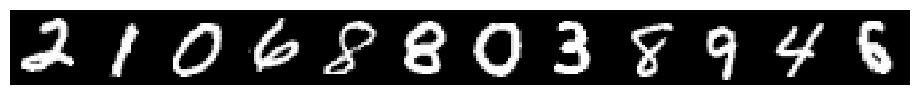

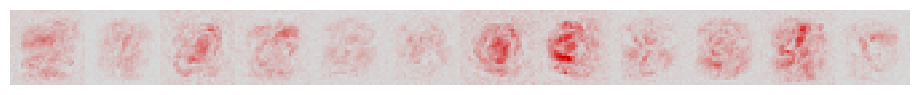

In [11]:
utils.digit(X.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)
utils.heatmap(R[0].reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)

In [12]:
import cv2
img = numpy.array(cv2.imread('castle.jpg'))[...,::-1]/255.0

In [13]:
img.shape

(224, 224, 3)

In [14]:
import torch

mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)

X = (torch.FloatTensor(img[numpy.newaxis].transpose([0,3,1,2])*1) - mean) / std

In [15]:
import torchvision

model = torchvision.models.vgg16(pretrained=True); model.eval()


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

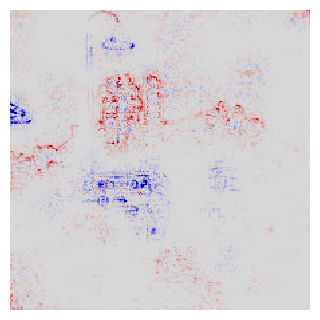

In [16]:
layers = list(model._modules['features']) + utils.toconv(list(model._modules['classifier']))
L = len(layers)
A = [X]+[None]*L
for l in range(L): A[l+1] = layers[l].forward(A[l])

scores = numpy.array(A[-1].data.view(-1))
ind = numpy.argsort(-scores)
# for i in ind[:10]:
#     print('%20s (%3d): %6.3f'%(utils.imgclasses[i][:20],i,scores[i]))

T = torch.FloatTensor((1.0*(numpy.arange(1000)==483).reshape([1,1000,1,1])))

R = [None]*L + [(A[-1]*T).data]

gamma = 10
epsilon = 1e-9
for l in range(1,L)[::-1]:
    
    A[l] = (A[l].data).requires_grad_(True)

    if isinstance(layers[l],torch.nn.MaxPool2d): layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):

        # if l <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9  
        # if 17 <= l <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        # # if 17 <= l <= 30: rho = lambda p: p + gamma*p.clamp(min=0) + 1e-4; incr = lambda z: z + gamma*z.clamp(min=0)  
        # if l >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9


        # # p : weight
        if l <= 10:       rho = lambda p: p ; incr = lambda z: z+epsilon
        if 11 <= l <= 20: rho = lambda p: p + gamma*p.clamp(min=0);     incr = lambda z: z+epsilon
        if 21 <= l <= 30: rho = lambda p: p;                       incr = lambda z: z+epsilon
        if l >= 31:       rho = lambda p: p;                       incr = lambda z: z+epsilon


        z = incr(utils.newlayer(layers[l],rho).forward(A[l]))  # step 1
        s = (R[l+1]/z).data                                    # step 2
        (z*s).sum().backward(); c = A[l].grad                  # step 3
        R[l] = (A[l]*c).data                                   # step 4
        
    else:
        
        R[l] = R[l+1]
# Modified

for i,l in enumerate([1]):
    utils.heatmap(numpy.array(R[l][0]).sum(axis=0),3,3)

In [32]:

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from PIL import Image


def heatmap(R):

    b = 10*((numpy.abs(R)**3.0).mean()**(1.0/3))

    my_cmap = plt.cm.seismic(numpy.arange(plt.cm.seismic.N))
    my_cmap[:,0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)
    return my_cmap,b

relevance_maps = []
os.makedirs('heatmap_images',exist_ok=True)
gamma_values = [0, 1, 10, 50, 100, 250, 500, 1000, 2500, 5000, 10000, 100000]
for gamma in gamma_values:
    

    layers = list(model._modules['features']) + utils.toconv(list(model._modules['classifier']))
    L = len(layers)
    A = [X] + [None] * L
    for l in range(L):
        A[l + 1] = layers[l].forward(A[l])

    scores = np.array(A[-1].data.view(-1))
    ind = np.argsort(-scores)

    T = torch.FloatTensor((1.0 * (np.arange(1000) == 483).reshape([1, 1000, 1, 1])))


    R = [None] * L + [(A[-1] * T).data] 
    
    for l in range(1, L)[::-1]:
        A[l] = A[l].data.requires_grad_(True)
        if isinstance(layers[l], torch.nn.MaxPool2d):
            layers[l] = torch.nn.AvgPool2d(2)
        
        if isinstance(layers[l], torch.nn.Conv2d) or isinstance(layers[l], torch.nn.AvgPool2d):
            if l <= 10:
                rho = lambda p: p
                incr = lambda z: z + epsilon
            elif 11 <= l <= 20:
                rho = lambda p: p + gamma * p.clamp(min=0)
                incr = lambda z: z + epsilon
            elif 21 <= l <= 30:
                rho = lambda p: p
                incr = lambda z: z + epsilon
            elif l>=31:
                rho = lambda p: p
                incr = lambda z: z + epsilon

            z = incr(utils.newlayer(layers[l], rho).forward(A[l]))  # step 1
            s = (R[l + 1] / z).data  # step 2
            (z * s).sum().backward()
            c = A[l].grad  # step 3
            R[l] = (A[l] * c).data  # step 4
        else:
            R[l] = R[l + 1]
        
    for i, l in enumerate([1]):
        my_cmap, b = heatmap(np.array(R[l][0]).sum(axis=0))
        
        plt.figure(figsize=(3, 3))
        plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.axis('off')
        plt.imshow(np.array(R[l][0]).sum(axis=0), cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
        
        # Save the figure instead of showing it
        plt.savefig(f'heatmap_images/heatmap_{gamma}.png')
        
        # Close the plot to free memory
        plt.close()

        



In [33]:


image_files = [os.path.join('heatmap_images', x) for x in os.listdir('heatmap_images')]

images = [Image.open(img) for img in image_files]

images[0].save('LRP.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=500, loop=0)


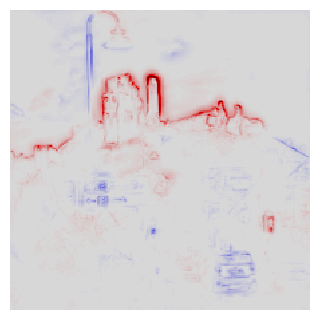

In [ ]:
# Original


for i,l in enumerate([1]):
    utils.heatmap(numpy.array(R[l][0]).sum(axis=0),3,3)

In [ ]:
A[0] = (A[0].data).requires_grad_(True)

lb = (A[0].data*0+(0-mean)/std).requires_grad_(True)
hb = (A[0].data*0+(1-mean)/std).requires_grad_(True)

z = layers[0].forward(A[0]) + 1e-9                                     # step 1 (a)
z -= utils.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
z -= utils.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
s = (R[1]/z).data                                                      # step 2
(z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad            # step 3
R[0] = (A[0]*c+lb*cp+hb*cm).data                                       # step 4

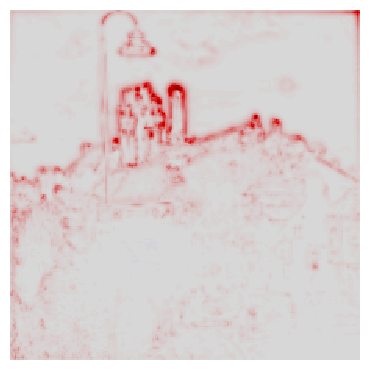

In [ ]:
utils.heatmap(numpy.array(R[0][0]).sum(axis=0),3.5,3.5)